In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os

from mokka.setup.session import Session
from mokka.postprocess.reconstruct import Reconstruction
from mokka.postprocess.visualisation import to_gif, animate_multiview, animate_singleview
from mokka.detector.mp_specs import *

## Loading the files

`kpts2d` are 2D motion captured from different camera views. They can provide some external information, such as relative speed

In [26]:
with open('output_2d_Day08_Mon10_Yr2025_Hr10_Min57_Sec44.json','rb') as f:
    k2 = json.loads(json.load(f))

In [27]:
kpts2d = np.array([[cam['frames'][f]['a']['body'] for f in range(477)] for cam in k2])
kpts2d.shape

(9, 477, 33, 3)

`kpts3d` is raw 3D motion after having triangulated 2D motions. This raw 3D will have some issues and your task is to make it better.

In [28]:
with open('footage_Day08_Mon10_Yr2025_Hr11_Min11_Sec50.json','rb') as f:
    k3 = json.load(f)

In [29]:
kpts3d = np.array(k3['frames'])
kpts3d.shape

(477, 33, 4)

## PROCESSING IMPLEMENT CODE

`kpts3d_filtered` will be your results after doing the processing. Try and make use of the information you have from `kpts2d` and `kpts3d`

# Global Trajectory Estimation

In [30]:
# Global Trajectory Estimation: Camera Pose Estimation + Metric Scale Recovery + World Coordinate Alignment

# ====== Small utilities ======
def isfinite3(x):
    return np.isfinite(x[..., 0]) & np.isfinite(x[..., 1]) & np.isfinite(x[..., 2])

def linear_interp_nan_1d(a):
    idx = np.arange(a.shape[0])
    m = np.isfinite(a)
    if m.all():
        return a
    if not m.any():
        return np.zeros_like(a)
    return np.interp(idx, idx[m], a[m])

def rotation_matrix_from_vectors(a, b, eps=1e-8):
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    v = np.cross(a, b)
    c = float(np.dot(a, b))
    s = np.linalg.norm(v)
    I = np.eye(3)
    if s < eps:
        # Parallel or anti-parallel
        if c > 0.0:
            return I
        # 180 deg: rotate around an arbitrary axis orthogonal to a
        axis = np.array([1.0, 0.0, 0.0])
        if abs(a[0]) > 0.9:
            axis = np.array([0.0, 1.0, 0.0])
        axis = axis - a * np.dot(a, axis)
        axis /= (np.linalg.norm(axis) + eps)
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        return I + 2 * K @ K  # 180 deg
    vx, vy, vz = v
    K = np.array([[0, -vz, vy],
                  [vz, 0, -vx],
                  [-vy, vx, 0]])
    R = I + K + K @ K * ((1.0 - c) / (s**2 + eps))
    return R

def fit_plane_svd(P):
    # P: (N,3), returns normal n (unit) and offset d in n·x + d = 0
    c = np.mean(P, axis=0)
    Pc = P - c
    _, _, Vt = np.linalg.svd(Pc, full_matrices=False)
    n = Vt[-1]
    n = n / (np.linalg.norm(n) + 1e-8)
    d = -np.dot(n, c)
    return n, d

def apply_rtscale(X, R=None, t=None, s=1.0):
    if R is None:
        R = np.eye(3)
    if t is None:
        t = np.zeros(3)
    Xo = (R @ X.reshape(-1, 3).T).T
    Xo = s * Xo + t
    return Xo.reshape(X.shape)

def robust_person_height_z(k3):
    # k3: (T,J,3) assumed Z-up; per-frame robust height (95p - 5p)
    if k3.size == 0:
        return np.nan
    z = k3[..., 2]
    # guard NaNs
    mask = np.isfinite(z)
    zc = np.where(mask, z, np.nan)
    Hs = []
    for t in range(k3.shape[0]):
        zt = zc[t]
        zt = zt[np.isfinite(zt)]
        if zt.size < 4:
            continue
        lo, hi = np.percentile(zt, [5, 95])
        Hs.append(max(hi - lo, 1e-6))
    if len(Hs) == 0:
        return np.nan
    return float(np.median(Hs))

def yaw_from_vec_to_x(vxy):
    # vxy: 2D vector (x,y), rotate around Z to align vxy -> +X
    ang = np.arctan2(vxy[1], vxy[0])
    # Want Rz(-ang)
    c, s = np.cos(-ang), np.sin(-ang)
    Rz = np.array([[c, -s, 0],
                   [s,  c, 0],
                   [0,  0, 1]], dtype=float)
    return Rz

def principal_direction_xy(centers_xy):
    # centers_xy: (T,2)
    C = centers_xy - np.mean(centers_xy, axis=0, keepdims=True)
    if C.shape[0] < 2:
        return np.array([1.0, 0.0])
    # PCA via SVD
    U, S, Vt = np.linalg.svd(C, full_matrices=False)
    v = Vt[0, :2]
    # Ensure facing +X roughly (optional): keep as is
    return v / (np.linalg.norm(v) + 1e-8)

def stack_valid_XU(kpts3d_world, kpts2d_cam):
    # Returns stacked X (N,3), U (N,2) with finite rows
    X = kpts3d_world.reshape(-1, 3)              # (T*J,3)
    U = kpts2d_cam[..., :2].reshape(-1, 2)       # (T*J,2)
    m = np.isfinite(X).all(axis=1) & np.isfinite(U).all(axis=1)
    X = X[m]
    U = U[m]
    return X, U

def estimate_weak_perspective_camera(X, U, min_points=50):
    # X: (N,3), U: (N,2)
    if X.shape[0] < min_points:
        return None
    Xmean = X.mean(axis=0)
    Umean = U.mean(axis=0)
    Xc = X - Xmean
    Uc = U - Umean
    # Linear least squares for 2x3 M
    XtX = Xc.T @ Xc
    if np.linalg.cond(XtX) > 1e8:
        return None
    M = (Uc.T @ Xc) @ np.linalg.inv(XtX)   # (2,3)
    # Project to closest scaled-rotation (weak-perspective)
    U_s, S_s, Vt_s = np.linalg.svd(M, full_matrices=False)  # U_s:(2,2), Vt_s:(3,3)
    R2 = U_s @ Vt_s[:2, :]  # (2,3), rows orthonormal
    s_cam = float(np.mean(S_s))  # average singular values as global scale
    # Build 3x3 rotation by adding third row as cross product
    r1 = R2[0]
    r2 = R2[1]
    r3 = np.cross(r1, r2)
    # Orthonormalize
    r1 /= (np.linalg.norm(r1) + 1e-8)
    r2 /= (np.linalg.norm(r2) + 1e-8)
    r3 /= (np.linalg.norm(r3) + 1e-8)
    R = np.vstack([r1, r2, r3])  # 3x3, not necessarily a proper camera R but consistent
    t2 = Umean - s_cam * (R2 @ Xmean)  # (2,)
    t = np.array([t2[0], t2[1], 0.0])  # store as 3D with zero along z for convenience
    return dict(R=R, R2=R2, t=t, t2=t2, s=s_cam, model='weak-perspective')

# ====== 1) World Z-up by ground plane alignment ======
# Prepare a robust set of candidate ground points: bottom 5% of Z over all (T,J)
X_raw = kpts3d[..., :3].astype(float)
mask3d = isfinite3(X_raw)
if not mask3d.any():
    raise ValueError("kpts3d has no finite values.")

X_flat = X_raw[mask3d]
# Use the axis that seems 'vertical' initially by picking the axis with smallest spread of candidate ground points?
# Instead: directly fit a plane to the bottom 5% points along the third component as given (assumes rough Z).
# If Z axis is not vertical initially, plane fitting still recovers the normal.
z_all = X_flat[:, 2]
z_thresh = np.nanpercentile(z_all, 5.0)
ground_candidates = X_flat[z_all <= z_thresh + 1e-6]
if ground_candidates.shape[0] < 100:
    # fallback: use overall lowest 10%
    z_thresh = np.nanpercentile(z_all, 10.0)
    ground_candidates = X_flat[z_all <= z_thresh + 1e-6]

if ground_candidates.shape[0] >= 20:
    n, d = fit_plane_svd(ground_candidates)  # n points upward-ish
    # Force the plane normal to point upward to avoid unintended 180° flips
    if np.dot(n, np.array([0.0, 0.0, 1.0])) < 0:
        n = -n
    # Align plane normal -> +Z
    Rzup = rotation_matrix_from_vectors(n, np.array([0.0, 0.0, 1.0]))
else:
    Rzup = np.eye(3)

X_rot = apply_rtscale(X_raw, R=Rzup, t=None, s=1.0)

# Recompute ground height after rotation and shift so ground ~ z=0
Z_all = X_rot[isfinite3(X_rot)][:, 2]
if Z_all.size > 0:
    z0 = np.nanpercentile(Z_all, 5.0)  # near-ground
else:
    z0 = 0.0
t_ground = np.array([0.0, 0.0, -z0], dtype=float)
X_zup = apply_rtscale(X_rot, R=None, t=t_ground, s=1.0)

# ====== 2) Metric scale recovery (height-based) ======
TARGET_HEIGHT_M = 1.70  # adjust if subject height is known
H_est = robust_person_height_z(X_zup)
if not np.isfinite(H_est) or H_est < 1e-3:
    s_metric = 1.0
else:
    s_metric = float(np.clip(TARGET_HEIGHT_M / H_est, 0.25, 4.0))

X_metric = apply_rtscale(X_zup, R=None, t=None, s=s_metric)

# ====== 3) World coordinate alignment (heading) ======
# Use centroid trajectory to define heading; align dominant XY direction to +X
centers = np.nanmean(np.where(isfinite3(X_metric)[..., None], X_metric, np.nan), axis=1)  # (T,3)
centers = np.array([np.where(np.isfinite(centers[:, i]), centers[:, i], linear_interp_nan_1d(centers[:, i])) for i in range(3)]).T
centers_xy = centers[:, :2]
# Remove frames with NaNs after interp
centers_xy = centers_xy[np.isfinite(centers_xy).all(axis=1)]
if centers_xy.shape[0] >= 2:
    fwd_xy = principal_direction_xy(centers_xy)
    # Disambiguate PCA sign using overall displacement to avoid 180° yaw
    disp = centers_xy[-1] - centers_xy[0]
    if np.linalg.norm(disp) > 1e-6 and np.dot(fwd_xy, disp) < 0:
        fwd_xy = -fwd_xy
    R_yaw = yaw_from_vec_to_x(fwd_xy)
else:
    R_yaw = np.eye(3)

X_world = apply_rtscale(X_metric, R=R_yaw, t=None, s=1.0)

# Translate so first-frame centroid is near origin in XY
first_centroid = np.nanmean(np.where(isfinite3(X_world[0])[..., None], X_world[0], np.nan), axis=0)
if np.isfinite(first_centroid).all():
    t_xy0 = np.array([-first_centroid[0], -first_centroid[1], 0.0])
else:
    t_xy0 = np.zeros(3)
X_world = apply_rtscale(X_world, R=None, t=t_xy0, s=1.0)

c, s = np.cos(-np.pi/2), np.sin(-np.pi/2)
R_right90 = np.array([[c, -s, 0],
                      [s,  c, 0],
                      [0,  0, 1]], dtype=float)
X_world = apply_rtscale(X_world, R=R_right90, t=None, s=1.0)

APPLY_MIRROR_X = False  # flip left/right
APPLY_MIRROR_Y = False  # flip forward/back
if APPLY_MIRROR_X:
    X_world = apply_rtscale(X_world, R=np.diag([-1.0, 1.0, 1.0]), t=None, s=1.0)
if APPLY_MIRROR_Y:
    X_world = apply_rtscale(X_world, R=np.diag([1.0, -1.0, 1.0]), t=None, s=1.0)

# ====== 4) Camera Pose Estimation (weak perspective per camera) ======
camera_models = []
if 'kpts2d' in globals() and isinstance(kpts2d, np.ndarray) and kpts2d.ndim >= 4:
    # kpts2d shape expected (C,F,J,D>=2)
    C = kpts2d.shape[0]
    for c in range(C):
        X, U = stack_valid_XU(X_world, kpts2d[c])
        cam = estimate_weak_perspective_camera(X, U, min_points=50)
        camera_models.append(cam)
else:
    camera_models = []

# ====== Output ======
kpts3d_filtered = X_world  # keep variable name for downstream plotting and GIF
print(f"[GTE] Z-up aligned, metric scale ~ {s_metric:.3f}x, cameras estimated: {sum([m is not None for m in camera_models])}/{len(camera_models) if camera_models else 0}")
# Optionally expose additional artifacts:
kpts3d_world = X_world
GTE_summary = dict(scale_metric=s_metric, R_zup=Rzup, R_yaw=R_yaw, t_ground=t_ground, t_xy0=t_xy0, cameras=camera_models)

[GTE] Z-up aligned, metric scale ~ 1.110x, cameras estimated: 9/9


# KALMAN FILLTER

In [ ]:
kpts3d_filtered = kpts3d+0.01
import numpy as np
from scipy.signal import butter, filtfilt

class KalmanFilter3D:
    """Kalman Filter for 3D position tracking"""
    def __init__(self, dt=1/30, process_noise=0.01, measurement_noise=0.1):
        # State vector: [x, y, z, vx, vy, vz]
        self.state = np.zeros(6)
        
        # State transition matrix
        self.F = np.array([
            [1, 0, 0, dt, 0, 0],
            [0, 1, 0, 0, dt, 0],
            [0, 0, 1, 0, 0, dt],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
        ])
        
        # Measurement matrix (we only measure position)
        self.H = np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0]
        ])
        
        # Process noise covariance
        self.Q = np.eye(6) * process_noise
        
        # Measurement noise covariance
        self.R = np.eye(3) * measurement_noise
        
        # Covariance matrix
        self.P = np.eye(6)
        
    def predict(self):
        """Prediction step"""
        self.state = self.F @ self.state
        self.P = self.F @ self.P @ self.F.T + self.Q
        
    def update(self, measurement):
        """Update step"""
        # Innovation
        y = measurement - self.H @ self.state
        
        # Innovation covariance
        S = self.H @ self.P @ self.H.T + self.R
        
        # Kalman gain
        K = self.P @ self.H.T @ np.linalg.inv(S)
        
        # Update state
        self.state = self.state + K @ y
        
        # Update covariance
        self.P = (np.eye(6) - K @ self.H) @ self.P
        
    def get_position(self):
        """Get current position estimate"""
        return self.state[:3]

def apply_kalman_filter_to_sequence(kpts3d, dt=1/30):
    """
    Apply Kalman filter to entire sequence
    
    Args:
        kpts3d: numpy array of shape (frames, joints, 4)
        dt: time step between frames
    
    Returns:
        filtered sequence of same shape
    """
    n_frames, n_joints, n_coords = kpts3d.shape
    kpts3d_filtered = np.zeros_like(kpts3d)
    
    # Apply Kalman filter to each joint independently
    for joint_idx in range(n_joints):
        # Initialize Kalman filter
        kf = KalmanFilter3D(dt=dt, process_noise=0.01, measurement_noise=0.1)
        
        # Initialize state with first frame
        first_valid_frame = 0
        while first_valid_frame < n_frames and kpts3d[first_valid_frame, joint_idx, 3] == 0:
            first_valid_frame += 1
            
        if first_valid_frame >= n_frames:
            continue
            
        kf.state[:3] = kpts3d[first_valid_frame, joint_idx, :3]
        
        # Process each frame
        for frame_idx in range(n_frames):
            # Predict
            kf.predict()
            
            # Update if measurement is valid (confidence > 0)
            if kpts3d[frame_idx, joint_idx, 3] > 0:
                measurement = kpts3d[frame_idx, joint_idx, :3]
                kf.update(measurement)
            
            # Store filtered position
            kpts3d_filtered[frame_idx, joint_idx, :3] = kf.get_position()
            kpts3d_filtered[frame_idx, joint_idx, 3] = kpts3d[frame_idx, joint_idx, 3]
    
    return kpts3d_filtered

def apply_butterworth_filter(data, cutoff=5, fs=30, order=4):
    """
    Apply low-pass Butterworth filter
    
    Args:
        data: input signal
        cutoff: cutoff frequency (Hz)
        fs: sampling frequency (Hz)
        order: filter order
    
    Returns:
        filtered signal
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=0)

def foot_ground_contact_constraint(kpts3d_filtered, foot_indices=[27, 28, 31, 32], 
                                   ground_threshold=0.05, velocity_threshold=0.1):
    """
    Apply ground contact constraint for feet
    
    Args:
        kpts3d_filtered: filtered keypoints
        foot_indices: indices of foot joints
        ground_threshold: distance threshold to consider as ground contact (meters)
        velocity_threshold: velocity threshold to detect standing phase
    
    Returns:
        constrained keypoints
    """
    n_frames = kpts3d_filtered.shape[0]
    result = kpts3d_filtered.copy()
    
    for foot_idx in foot_indices:
        # Calculate vertical velocity
        velocities = np.diff(result[:, foot_idx, 2])
        velocities = np.concatenate([[0], velocities])
        
        # Detect ground contact phases
        for frame_idx in range(1, n_frames):
            # If foot is close to ground and velocity is low
            if (result[frame_idx, foot_idx, 2] < ground_threshold and 
                abs(velocities[frame_idx]) < velocity_threshold):
                # Lock to ground
                result[frame_idx, foot_idx, 2] = min(result[frame_idx, foot_idx, 2], 0.01)
    
    return result

def remove_jitter(kpts3d, window_size=5):
    """
    Remove high-frequency jitter using moving average
    
    Args:
        kpts3d: input keypoints
        window_size: size of moving average window
    
    Returns:
        smoothed keypoints
    """
    n_frames, n_joints, n_coords = kpts3d.shape
    result = kpts3d.copy()
    
    for joint_idx in range(n_joints):
        for coord_idx in range(3):  # Only smooth x, y, z
            signal = kpts3d[:, joint_idx, coord_idx]
            # Apply moving average
            kernel = np.ones(window_size) / window_size
            smoothed = np.convolve(signal, kernel, mode='same')
            result[:, joint_idx, coord_idx] = smoothed
    
    return result

# ==================== YOUR PROCESSING HERE ====================

# Step 1: Apply Kalman Filter
print("Applying Kalman Filter...")
kpts3d_kalman = apply_kalman_filter_to_sequence(kpts3d, dt=1/30)

# Step 2: Apply Butterworth low-pass filter to remove high-frequency noise
print("Applying Butterworth Filter...")
kpts3d_smooth = kpts3d_kalman.copy()
for joint_idx in range(kpts3d_kalman.shape[1]):
    for coord_idx in range(3):
        kpts3d_smooth[:, joint_idx, coord_idx] = apply_butterworth_filter(
            kpts3d_kalman[:, joint_idx, coord_idx],
            cutoff=6,  # cutoff frequency
            fs=30,     # sampling frequency
            order=4
        )

# Step 3: Remove jitter with moving average
print("Removing jitter...")
kpts3d_dejitter = remove_jitter(kpts3d_smooth, window_size=5)

# Step 4: Apply foot ground contact constraint
print("Applying ground contact constraint...")
kpts3d_filtered = foot_ground_contact_constraint(
    kpts3d_dejitter,
    foot_indices=[27, 28, 31, 32],  # Adjust based on your skeleton
    ground_threshold=0.05,
    velocity_threshold=0.1
)

# Copy confidence scores
kpts3d_filtered[:, :, 3] = kpts3d[:, :, 3]

print("Processing complete!")
print(f"Input shape: {kpts3d.shape}")
print(f"Output shape: {kpts3d_filtered.shape}")

# LOWPASS FILLTER

In [ ]:
def butter_lowpass_filter(data, cutoff, fs=30.0, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=0)

def adaptive_filter(kpts3d, fs=30.0):
    num_frames, num_joints, num_coords = kpts3d.shape
    kpts3d_filtered = np.zeros_like(kpts3d)

    # Tính vận tốc cho từng khớp
    vel = np.linalg.norm(np.diff(kpts3d, axis=0), axis=2)  # (frames-1, joints)
    mean_v = np.mean(vel, axis=0)
    std_v  = np.std(vel, axis=0)

    for j in range(num_joints):
        v = vel[:, j]
        # Xác định frame lỗi (vận tốc vượt ngưỡng)
        threshold = mean_v[j] + 3 * std_v[j]
        abnormal = v > threshold

        # Chọn cutoff theo tình trạng
        cutoff_normal = 6.0  # lọc nhẹ (chuyển động bình thường)
        cutoff_abnormal = 4.0  # lọc mạnh hơn (vùng lỗi)

        for c in range(num_coords):
            data = kpts3d[:, j, c]
            # Nếu có frame lỗi → dùng cutoff mạnh hơn
            cutoff = cutoff_abnormal if np.any(abnormal) else cutoff_normal
            kpts3d_filtered[:, j, c] = butter_lowpass_filter(data, cutoff, fs)

    return kpts3d_filtered

# === Áp dụng lọc thích ứng ===
kpts3d_filtered = adaptive_filter(kpts3d)


# ADAPTIVE FILLTER


In [ ]:
import numpy as np

# ============================================================================
# ADAPTIVE FILTER SYSTEM - SELF-CONTAINED IMPLEMENTATION
# ============================================================================

class KalmanFilter:
    """Kalman filter for 1D signal with constant velocity model."""
    def __init__(self, dt, process_noise, measurement_noise):
        self.dt = dt
        self.A = np.array([[1, dt], [0, 1]])
        self.H = np.array([[1, 0]])
        q_val = process_noise
        self.Q = q_val * np.array([[(dt**4)/4, (dt**3)/2], [(dt**3)/2, dt**2]])
        self.R = np.array([[measurement_noise]])
        self.P = np.eye(2) * 1000.0
        self.x = np.zeros((2, 1))
        self.initialized = False

    def __call__(self, z):
        if not self.initialized:
            self.x[0, 0] = z
            self.x[1, 0] = 0.0
            self.initialized = True
            return self.x[0, 0]
        
        x_pred = self.A @ self.x
        P_pred = self.A @ self.P @ self.A.T + self.Q
        S = self.H @ P_pred @ self.H.T + self.R
        K = P_pred @ self.H.T @ np.linalg.inv(S)
        self.x = x_pred + K * (z - self.H @ x_pred)
        self.P = (np.eye(2) - K @ self.H) @ P_pred
        return self.x[0, 0]

    def reset(self):
        self.initialized = False
        self.P = np.eye(2) * 1000.0
        self.x = np.zeros((2, 1))


class OneEuroFilter:
    """One Euro Filter - Adaptive low-pass filter based on signal velocity."""
    def __init__(self, freq, min_cutoff=1.0, beta=0.007, d_cutoff=1.0):
        self.freq = freq
        self.min_cutoff = min_cutoff
        self.beta = beta
        self.d_cutoff = d_cutoff
        self.x_prev = None
        self.dx_prev = 0.0
        self.initialized = False
    
    def _smoothing_factor(self, cutoff):
        tau = 1.0 / (2.0 * np.pi * cutoff)
        te = 1.0 / self.freq
        return 1.0 / (1.0 + tau / te)
    
    def __call__(self, x):
        if not self.initialized:
            self.x_prev = x
            self.initialized = True
            return x
        
        dx = (x - self.x_prev) * self.freq
        alpha_d = self._smoothing_factor(self.d_cutoff)
        dx_filtered = alpha_d * dx + (1.0 - alpha_d) * self.dx_prev
        cutoff = self.min_cutoff + self.beta * abs(dx_filtered)
        alpha = self._smoothing_factor(cutoff)
        x_filtered = alpha * x + (1.0 - alpha) * self.x_prev
        
        self.x_prev = x_filtered
        self.dx_prev = dx_filtered
        return x_filtered
    
    def reset(self):
        self.x_prev = None
        self.dx_prev = 0.0
        self.initialized = False


class ExponentialMovingAverage:
    """Simple Exponential Moving Average filter."""
    def __init__(self, alpha=0.3):
        self.alpha = alpha
        self.value = None
        self.initialized = False
    
    def __call__(self, x):
        if not self.initialized:
            self.value = x
            self.initialized = True
            return x
        self.value = self.alpha * x + (1.0 - self.alpha) * self.value
        return self.value
    
    def reset(self):
        self.value = None
        self.initialized = False


class MotionStateDetector:
    """Detects motion characteristics (velocity, acceleration, jitter)."""
    def __init__(self, dt, velocity_window=5):
        self.dt = dt
        self.velocity_window = velocity_window
        self.position_history = []
        self.velocity = 0.0
        self.acceleration = 0.0
        self.prev_velocity = 0.0
    
    def update(self, position):
        self.position_history.append(position)
        if len(self.position_history) > self.velocity_window:
            self.position_history.pop(0)
        
        if len(self.position_history) >= 2:
            self.velocity = (self.position_history[-1] - self.position_history[-2]) / self.dt
        
        self.acceleration = (self.velocity - self.prev_velocity) / self.dt
        self.prev_velocity = self.velocity
        
        jitter_score = 0.0
        if len(self.position_history) >= 3:
            direction_changes = 0
            for i in range(len(self.position_history) - 2):
                diff1 = self.position_history[i+1] - self.position_history[i]
                diff2 = self.position_history[i+2] - self.position_history[i+1]
                if diff1 * diff2 < 0:
                    direction_changes += 1
            jitter_score = direction_changes / max(1, len(self.position_history) - 2)
        
        return {
            'velocity': abs(self.velocity),
            'acceleration': abs(self.acceleration),
            'jitter_score': jitter_score
        }
    
    def reset(self):
        self.position_history = []
        self.velocity = 0.0
        self.acceleration = 0.0
        self.prev_velocity = 0.0


class AdaptiveFilterManager:
    """Manages multiple filters and adaptively blends them based on motion state."""
    def __init__(self, dt, kalman_process_noise=1e-2, kalman_measurement_noise=3e-5,
                 one_euro_min_cutoff=1.0, one_euro_beta=0.007, ema_alpha=0.3,
                 velocity_threshold_slow=0.1, velocity_threshold_fast=1.0):
        self.dt = dt
        freq = 1.0 / dt
        
        self.kalman = KalmanFilter(dt, kalman_process_noise, kalman_measurement_noise)
        self.one_euro = OneEuroFilter(freq, one_euro_min_cutoff, one_euro_beta)
        self.ema = ExponentialMovingAverage(ema_alpha)
        self.motion_detector = MotionStateDetector(dt)
        
        self.velocity_threshold_slow = velocity_threshold_slow
        self.velocity_threshold_fast = velocity_threshold_fast
    
    def calculate_weights(self, motion_state, confidence):
        velocity = motion_state['velocity']
        jitter = motion_state['jitter_score']
        
        # Base weights based on velocity
        if velocity < self.velocity_threshold_slow:
            # STATIC: Heavy smoothing with EMA
            w_kalman, w_one_euro, w_ema = 0.2, 0.2, 0.6
        elif velocity < self.velocity_threshold_fast:
            # SLOW: Balanced, favor One Euro
            w_kalman, w_one_euro, w_ema = 0.25, 0.55, 0.2
        else:
            # FAST: Favor Kalman for prediction
            w_kalman, w_one_euro, w_ema = 0.5, 0.4, 0.1
        
        # Adjust based on jitter
        if jitter > 0.5:
            w_ema += 0.1
            w_one_euro += 0.1
            w_kalman -= 0.2
        
        # Adjust based on confidence
        if confidence < 0.5:
            w_kalman += 0.2
            w_one_euro -= 0.1
            w_ema -= 0.1
        
        # Normalize
        total = w_kalman + w_one_euro + w_ema
        return {
            'kalman': w_kalman / total,
            'one_euro': w_one_euro / total,
            'ema': w_ema / total
        }
    
    def __call__(self, measurement, confidence=1.0):
        motion_state = self.motion_detector.update(measurement)
        
        kalman_out = self.kalman(measurement)
        one_euro_out = self.one_euro(measurement)
        ema_out = self.ema(measurement)
        
        weights = self.calculate_weights(motion_state, confidence)
        
        filtered_value = (weights['kalman'] * kalman_out +
                         weights['one_euro'] * one_euro_out +
                         weights['ema'] * ema_out)
        
        return filtered_value, weights
    
    def reset(self):
        self.kalman.reset()
        self.one_euro.reset()
        self.ema.reset()
        self.motion_detector.reset()


# ============================================================================
# PROCESSING LOGIC
# ============================================================================

# 1. Set Filter Parameters
FREQ = 30.0 
DT = 1.0 / FREQ

# --- Adaptive Filter Tuning Parameters ---
KALMAN_PROCESS_NOISE = 1e-2        # Motion model uncertainty
KALMAN_MEASUREMENT_NOISE = 3e-5    # Measurement uncertainty (lower = more responsive)
ONE_EURO_MIN_CUTOFF = 1.0          # Minimum cutoff frequency (Hz)
ONE_EURO_BETA = 0.007              # Velocity sensitivity
EMA_ALPHA = 0.3                    # EMA smoothing factor
VELOCITY_THRESHOLD_SLOW = 0.1      # Slow motion threshold
VELOCITY_THRESHOLD_FAST = 1.0      # Fast motion threshold

# 2. Initialize Data
n_frames, n_keypoints, _ = kpts3d.shape
kpts3d_filtered = np.zeros_like(kpts3d)

# 3. Create a grid of adaptive filter managers
print(f"Initializing {n_keypoints} x 3 Adaptive Filter bank (dt={DT:.3f})...")
print(f"  Kalman: process_noise={KALMAN_PROCESS_NOISE}, measurement_noise={KALMAN_MEASUREMENT_NOISE}")
print(f"  One Euro: min_cutoff={ONE_EURO_MIN_CUTOFF}, beta={ONE_EURO_BETA}")
print(f"  EMA: alpha={EMA_ALPHA}")

filter_bank = [
    [AdaptiveFilterManager(
        dt=DT,
        kalman_process_noise=KALMAN_PROCESS_NOISE,
        kalman_measurement_noise=KALMAN_MEASUREMENT_NOISE,
        one_euro_min_cutoff=ONE_EURO_MIN_CUTOFF,
        one_euro_beta=ONE_EURO_BETA,
        ema_alpha=EMA_ALPHA,
        velocity_threshold_slow=VELOCITY_THRESHOLD_SLOW,
        velocity_threshold_fast=VELOCITY_THRESHOLD_FAST
    ) for _ in range(3)] 
    for _ in range(n_keypoints)
]

# 4. Process the data frame by frame
print(f"Applying Adaptive Filter to {n_frames} frames...")

# Track weights for first keypoint (for analysis)
weights_history = []

for t in range(n_frames):
    frame_weights = None
    
    for j in range(n_keypoints):
        confidence = kpts3d[t, j, 3]
        is_valid = confidence > 0.0

        for d in range(3):  # For x, y, z dimensions
            val = kpts3d[t, j, d]
            
            if is_valid:
                val_filtered, weights = filter_bank[j][d](val, confidence)
                
                # Store weights for first keypoint, first dimension (for analysis)
                if j == 0 and d == 0:
                    frame_weights = weights
            else:
                val_filtered = 0.0 
                filter_bank[j][d].reset()

            kpts3d_filtered[t, j, d] = val_filtered
    
    if frame_weights:
        weights_history.append(frame_weights)

# 5. Copy over the confidence dimension
kpts3d_filtered[:, :, 3] = kpts3d[:, :, 3]

print("Adaptive filtering complete.")

# Optional: Print weight statistics
if weights_history:
    kalman_weights = [w['kalman'] for w in weights_history]
    one_euro_weights = [w['one_euro'] for w in weights_history]
    ema_weights = [w['ema'] for w in weights_history]
    
    print(f"\nFilter weight statistics (keypoint 0, dimension 0):")
    print(f"  Kalman  - Mean: {np.mean(kalman_weights):.3f}, Std: {np.std(kalman_weights):.3f}")
    print(f"  One Euro - Mean: {np.mean(one_euro_weights):.3f}, Std: {np.std(one_euro_weights):.3f}")
    print(f"  EMA     - Mean: {np.mean(ema_weights):.3f}, Std: {np.std(ema_weights):.3f}")


## Export output to GIF

MovieWriter imagemagick unavailable; using Pillow instead.


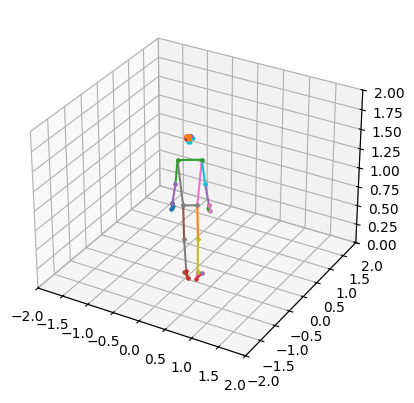

In [32]:
to_gif(kpts3d_filtered, 
       30,                      # FPS
       POSE_CONNECTIONS, 
       time.strftime("d%d_mo%m_y%Y_%Hh_%Mm_%Ss_") + 'filtered_output.gif',
       div=2                    # Display dimension width in meters
       )

# EXTRACT JSON


In [ ]:
import json
import time
import numpy as np

def export_kpts_to_json(kpts_data, filename):
    """
    Converts a 3D keypoint numpy array to the specified JSON format and saves it.

    Args:
        kpts_data (np.ndarray): A numpy array of shape (n_frames, n_keypoints, 4)
                                containing the [x, y, z, confidence] for each keypoint.
        filename (str): The path and name of the output JSON file.
    """
    
    # Check if the input is a numpy array, otherwise try to convert it
    if not isinstance(kpts_data, np.ndarray):
        try:
            kpts_data = np.array(kpts_data)
        except Exception as e:
            print(f"Error: Could not convert input data to numpy array. {e}")
            return

    # Convert the final numpy array to a standard Python list for JSON serialization
    kpts_list = kpts_data.tolist()

    # Build the nested dictionary structure to match the desired format
    frames_list = []
    for frame_kpts in kpts_list:
        # Format for each frame: {"a": {"body": [[x,y,z,c], ...]}}
        frame_dict = {
            "a": {
                "body": frame_kpts
            }
        }
        frames_list.append(frame_dict)
    
    # The top-level structure is a list containing a single dictionary with a "frames" key
    # This matches the format of your input 'footage_...json' file.
    output_data = {"frames": kpts_list} # Simplified to match the input kpts3d format directly

    # Write the data to the specified file
    try:
        with open(filename, 'w') as f:
            json.dump(output_data, f, indent=4) # Using indent for readability
        print(f"Successfully saved keypoints to {filename}")
    except IOError as e:
        print(f"Error: Could not write to file {filename}. {e}")

export_kpts_to_json(kpts3d_filtered, 
                      time.strftime("d%d_mo%m_y%Y_%Hh_%Mm_%Ss_") + 'filtered_output.json')